# Bayesian Statistics, Bayesian Concept Learning and Bayesian Deep Learning

**Bayesian Statistics**

Bayesian statistics is a paradigm centered on the Bayesian interpretation of probabilities. In this framework, a probability represents a degree of belief in a given event. This prior belief can be informed by previous knowledge. Using Bayesian statistical methods, we apply Bayes' theorem to compute updated probabilities based on new observed data. 

Recall Bayes' rule:

$
P(H | D) = \frac{P(D | H) P(H)}{P(D)}
$

- $H$ is a proposition or hypothesis.
- $D$ is the evidence, which in this context refers to our data.
- $P(H)$ is the prior probability of the hypothesis.
- $P(D | H)$ is the likelihood of the evidence given the hypothesis, i.e., the likelihood of the data assuming the hypothesis is true.
- $P(H | D)$ is the posterior probability of our hypothesis given the data.
-  $P(D)$ is the evidence (also referred as the marginal lieklihood), which ensures the posterior is a proper probability distribution.

To sum up The prior $P(H)$ reflects our initial belief about the hypothesis before observing any data. The likelihood $P(D|H)$ is the probability of observing the data $D$, assuming the hypothesis $H$ is true. The posterior $P(H|D)$ represents our updated belief about the hypothesis after observing the data. Essentially, Bayes’ theorem updates one’s prior beliefs $P(H)$ in light of the new data $D$.

**Bayesian Concept Learning** 

Bayes’ theorem can estimate the parameters of a probability distribution or statistical model. Since Bayesian statistics treats probability as a degree of belief, Bayes’ theorem allows us to assign a probability distribution that quantifies our belief about the parameter or set of parameters. Hence, it can be used to train a predictor $p(y | x, \theta)$ parametrized by $\theta$ by learning from the data ${x,y} \in D$, more precisely we aim to estimate the parameters $\theta$ of the model $p(y|x, \theta)$ that best explains the data. By applying Bayes' theorem, we can assign a probability distribution to these parameters that quantifies our belief about their values given the data. The key to developing such a Bayesian learning model is to properly fit the posterior $p(\theta | D)$  by  finding a suitable likelihood $p(D | \theta)$.

**Bayesian Neural Networks**

From this prior knowledge, we can adopt a Bayesian approach to deep learning, where a neural network serves as the predictor $p(y∣x,\theta)$. Unlike standard neural networks with fixed weights, a Bayesian Neural Network (BNN) is stochastic in its set of parameters (or activations). This allows us to sample multiple sets of parameters 
$\theta$ from the posterior, yielding mutliple models, thus making analogous to ensemble learning. 

The posterior is thus of the form :

\begin{align*}
 p(\theta | D) = \frac{p(D | \theta)p(\theta)}{p(D)} = \frac{p(D | \theta)p(\theta)}{ \int_{\theta'} p(y | x, \theta') p(\theta')d\theta'}.
\end{align*}

In most cases, the evidence $p(D)$ is intractable because it requires integrating over the entire parameter space, which is computationally expensive. Therefore, we rely methods to estimate the posterior.

**How to make prediction with a BNN**

Once a proper posterior distribution is fitted, predictions can be made by sampling multiple sets of parameters from the posterior distribution. Using our BNN, we can make predictions in the following manner :

\begin{align*}
    p(y | x, D) = \int_{\theta'} p(y|x, \theta') p(\theta' | D) d\theta'.
\end{align*}

In practice $p(y|x, \theta')$ is a forward pass in the BNN. Using Bayesian Model Averaging (BMA), we sample a set of $\theta_i$ from the posterior, assign those parameters to the model and compute $p(y|x, \theta_i)$.
By calculating statistics from these sampled predictions, we can not only make point predictions by averaging over the samples but also quantify the uncertainty in our predictions by examining the spread of the sampled values.

**Fit the posterior of a BNN**

Multiple techniques exist to fit the posterior distribution of a BNN. Two main families of methods are Markov Chain Monte Carlo (MCMC) and Variational Inference (VI). The aim of MCMC techniques is to sample from the exact posterior distribution, whereas VI techniques attempt to learn an approximate distribution and optimize it to be as close as possible to the original posterior. In this notebook, we will focus on a basic MCMC algorithm: Metropolis-Hastings.

# MCMC and Metropolis-Hastings algorithm

MCMC are sampling techniques used to fit a desired distribution. The aim of MCMC algorithm is to construct a Markov Chain of random Samples $S_i$ parametrized by previous sample $S_{i-1}$ in order to have a $S_i$ distributed according to a desired distribution. Since it starts at an arbitrary point the early samples are not representative of the target distributions, we referer to these early states as the burn-in period. After a period of time the markov will ultimately converge to the desired distribution. These methods are computationally expensive but allows to sample the exact posterior distribution in Bayesian settings.

One the most popular MCMC algorithm is the Metropolis-Hastings algorithm.

![Metropolis-Hastings]('figs/Metropolis-Hastings.png')

In the case of BNN, our goal is to samples parameters from $p(\theta | D)$, to do so, we have to define our target distribution; represented by $f(\theta)$. Sampling from $p(\theta | D)$ is still intractable because of the evidence, but the evidence is juste used to normalize $p(D | \theta)p(\theta)$ to ensure the posterior integrates to 1. Instead we can rely on the fact that the posterior is proportional to the likelihood times the prior : 

$p(\theta | D) \propto p(D | \theta) p(\theta)$, 

which is sufficient for the algorithm, thus in our case $f(\theta) = p(D | \theta)p(\theta)$. 

A proposal distribution $Q(\theta' | \theta_n)$ is also needed, it is parametrized around the previous parameter $\theta_n$ and will be used to propose new samples from the posterior. 


Here is what happens inside the algorithm :

1. First, we take a random guess $\theta_0$. 
2. We sample a proposal $\theta'$, from the proposal distribution $Q(\theta' | \theta_n)$.
3. We check if the proposal is more likely than the previous $\theta$ according to target distribution represented by $f(\theta)$, using  $min(1, \frac{ Q(\theta' | \theta_n)}   {Q(\theta_n | \theta')}   \frac{f(\theta')}{f(\theta_n)})$.
    4. If more likely we accept,
    9. If less likely it is accepted according to a certain probability,
    10. rejected o.w.

In practice:
1. the first random guess can be the model's initial random parameters. 
2. We can choose a symetric proposal distribution to simplify the algorithm. For example $\mathcal{N}(\theta_n, \sigma^2)$ or $\mathcal{U}(\theta_n - \epsilon, \theta_n + \epsilon)$. Using this approach the acceptance criterion becomes $min(1, \frac{f(\theta')}{f(\theta)})$

In [4]:
import torch
from torch import nn

import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_moons

from tqdm import tqdm

For the proposal distribution, we chose $\mathcal{N}(\theta_n, \sigma^2)$. The proposal's standard deviation has a significant impact on the acceptance rate. If it is too large, the acceptance rate will be very low or even zero; if it is too small, the samples will be highly autocorrelated. Selecting an appropriate standard deviation is part of the hyperparameter tuning process.

In [5]:
def propose_new_params(current_params, proposal_std=0.05):
    proposed_params = {}
    for name, param in current_params.items():
        proposed_params[name] = torch.normal(mean=param, std=proposal_std)
    return proposed_params

In [6]:
def metropolis_hastings(model, x, y, n_samples=1000, proposal_std=0.05):
    current_params = model.state_dict() # initial probability distribution
    current_log_post = model.log_posterior(x, y)
    
    samples = []
    accept_rate = 0

    for _ in tqdm(range(n_samples)):
        new_params = propose_new_params(current_params, proposal_std)

        model.load_state_dict(new_params)
        new_log_post = model.log_posterior(x, y)

        acceptance_prob = torch.exp(new_log_post - current_log_post).item()  

        if np.random.rand() < min(1, acceptance_prob):  
            accept_rate += 1
            current_params = new_params
            current_log_post = new_log_post

            samples.append(current_params.copy())

        model.load_state_dict(current_params)
    
    print(f'Acceptance rate: {accept_rate / n_samples}')
    return samples

# BNN with Metropolis-Hastings 

Let's implement a basic BNN for a regression task first.

We have to make some assumptions to define how prior, likelihood and posterior will be computed. First, for numerical stability, all probabilities are computed in the log space, as working with probabilities, they can become very small. 

**Prior function**

We have to define our prior belief about the model's parameter, in the context of bayesian neural networks, the prior distribution acts as regularization over the weights. For sake of simplicity we will define the  prior as a standard Normal Distribution $\mathcal{N}(0, I)$.  

As we are computing probabilities in the log space, the log prior is : 

\begin{align*}
    log(p(\theta)) &= log \left( \frac{1}{\sqrt{2\pi}}exp(-\frac{\theta^2}{2}) \right) \\
                   &= -\frac{1}{2}log(2\pi) - \frac{\theta^2}{2}
\end{align*}

$log(2\pi)$ is a constant, it will have no impact in the acceptance probability, so it can be omitted. Therefor the simplified log prior becomes : $-\frac{\theta^2}{2}$. 

**Likelihood function for a regression task**

In the case of a regression task, we assume that the data likelihood follows a Gaussian distribution. Specifically, we assume the outputs $y$ are normally distributed around the model's predictions $f(x, \theta)$. The likelihood function is given by:
$
    p(y | x, \theta) = \mathcal{N}(f(x, \theta), \sigma^2).
$
Hence the log likelihood is computed as follows : 

\begin{align*}
    p(x,y | \theta) & = \frac{1}{\sqrt{(2\pi\sigma^2)}}exp\left(-\frac{(x - f(x, \theta))^2)}{2\sigma^2}\right) \\
                    & = -\frac{1}{2}(x - f(x, \theta))^2
\end{align*}

with ${x, y} \in D$

**Posterior function**

As mentionned, posterior distribution is proportional to the likelihood times the prior : 

\begin{align*}
    p(\theta | D) \propto p(D | \theta) p(\theta)  
\end{align*}

hence 

\begin{align*}
    log(p(\theta | D)) & \propto log(p(D | \theta) p(\theta)) \\    
                       & \propto log(p(D  | \theta) + log(p(\theta))
\end{align*}



In [7]:
class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()
        self.dense1 = nn.Linear(1, 16) 
        self.dense2 = nn.Linear(16, 1)
        self.relu = torch.nn.ReLU()

        # setting the weights as standard normal 
        torch.nn.init.normal_(self.dense1.weight, mean=0, std=1)
        torch.nn.init.normal_(self.dense2.weight, mean=0, std=1)

    def forward(self, x):
        out = self.dense1(x)
        out = self.relu(out)
        out = self.dense2(out)
        return out
    
    def log_likelihood(self, x, y, noise_std=1.0):
        preds = self.forward(x)
        return -0.5 * torch.sum((preds - y)**2 / noise_std**2)

    def log_prior(self):
        log_prior = 0
        for param in self.parameters():
            log_prior += -0.5 * torch.sum(param ** 2)  
        return log_prior

    def log_posterior(self, x, y):
        return self.log_prior() + self.log_likelihood(x, y)

# Regression data

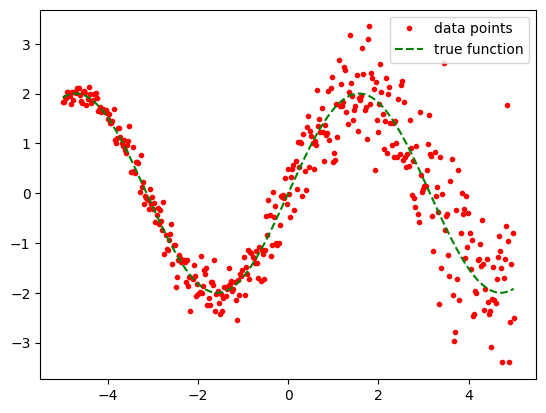

In [8]:
torch.manual_seed(0)
X = torch.linspace(-5, 5, 400).unsqueeze(1)

noise = (0.5 + 0.5 * torch.sin(0.2 * X))  
y = 2 * torch.sin(X) + torch.randn(X.size()) * noise

plt.plot(X, y, 'r.', label='data points')
plt.plot(X, 2*torch.sin(X), 'g--', label='true function')
plt.legend()

In [14]:
model = BNN()
samples = metropolis_hastings(model, X, y, proposal_std=0.08, n_samples=10000)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2608.56it/s]

Acceptance rate: 0.0101


# BMA 

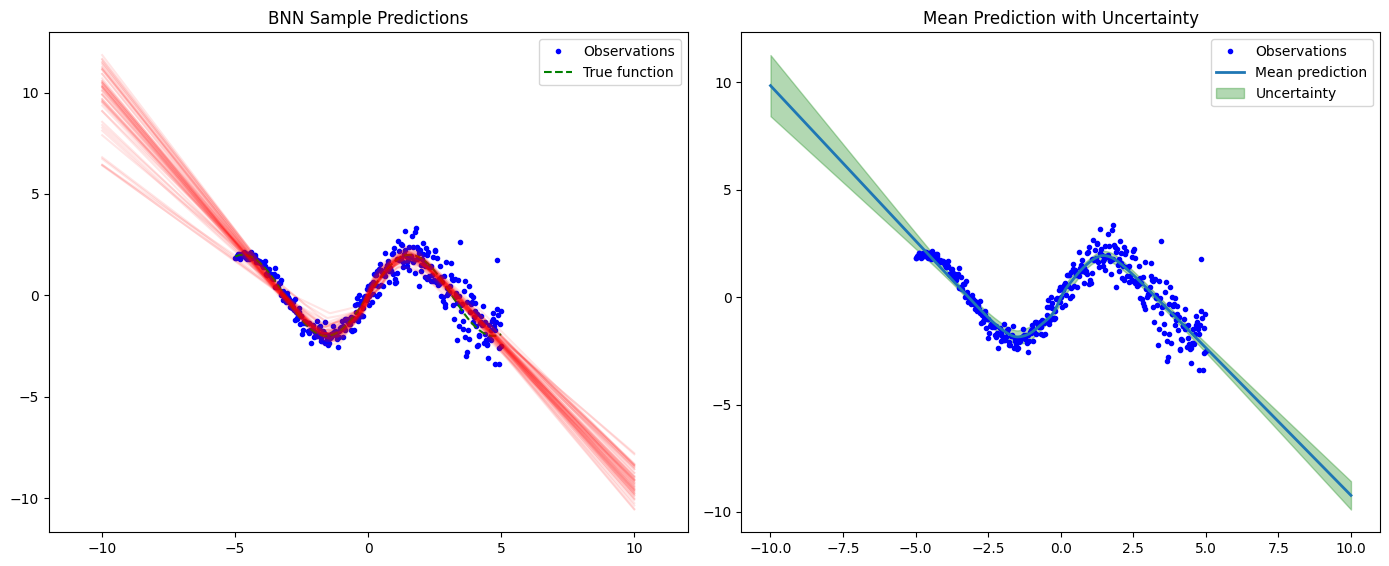

In [21]:
X_test = torch.linspace(-5, 5, 400).unsqueeze(1)
X_test_extended = torch.linspace(-10, 10, 400).unsqueeze(1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('BNN Sample Predictions')
axes[0].set_xlim(-12, 12)
axes[0].plot(X_test.detach(), y.numpy(), 'b.', label='Observations')
axes[0].plot(X_test.detach(), 2 * torch.sin(X_test).numpy(), 'g--', label='True function')

# The first states of the markov chain are not used as it may have not converged yet.
burn_in = round(len(samples) / 2)
mean_pred = np.zeros((len(samples[burn_in:]), X_test_extended.size(0)))

# we make a prediction with each sampled weights from the posterior
for i, sample in enumerate(samples[burn_in:]):
    model.load_state_dict(sample)
    prediction = model(X_test_extended).detach()
    axes[0].plot(X_test_extended.detach(), prediction, 'r', alpha=0.1)
    mean_pred[i] = prediction.squeeze()
    
std_pred = np.std(mean_pred, axis=0)
mean_pred = np.mean(mean_pred, axis=0)

axes[0].legend()

axes[1].set_title('Mean Prediction with Uncertainty')
axes[1].plot(X_test.detach(), y.numpy(), 'b.', label='Observations')
axes[1].plot(X_test_extended.detach(), mean_pred, label='Mean prediction', linewidth=2.0)
axes[1].fill_between(
    X_test_extended.detach().squeeze(),
    (mean_pred - std_pred).squeeze(),
    (mean_pred + std_pred).squeeze(),
    color='g',
    alpha=0.3,
    label='Uncertainty'
)
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

We observe that each parameter sampled from the posterior distribution results in a different regression function. The point estimate of the prediction is, therefore, the mean of all these regression functions, while the variance of these predictions reflects the uncertainty in the parameters

# BNN for classification

For a binary classification task, the log likelihood function differs because we assume our output follows a Bernoulli distribution. Thus:

\begin{align*}
    p(x, y | \theta) = f(x, \theta)^y (1 - f(x,  \theta))^{(1 - y)}
\end{align*}

The log likelihood becomes:

\begin{align*}
   log(p(x, y | \theta)) &= log(f(x, \theta)^y (1 - f(x,  \theta))^{(1 - y)}) \\
                         &= y\;log(f(x, \theta)) +  (1 - y)log(1 - f(x,  \theta)) \\ 
                         &= y\;log(f(x, \theta)) +  (1 - y)log(1 - f(x,  \theta)) \\ 
\end{align*}


In [99]:
class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()
        self.dense1 = nn.Linear(2, 10)
        self.dense2 = nn.Linear(10, 1)
        self.relu = torch.nn.ReLU()
        
        torch.nn.init.normal_(self.dense1.weight, mean=0, std=1)
        torch.nn.init.normal_(self.dense2.weight, mean=0, std=1)

    def forward(self, x):
        out = self.dense1(x)
        out = self.relu(out)
        out = self.dense2(out)
        
        out = torch.sigmoid(out)
        return out

    def log_likelihood(self, x, y):
        preds = self.forward(x)
        likelihood = y * torch.log(preds) + (1 - y) * torch.log(1 - preds)
        return torch.sum(likelihood)

    def log_prior(self):
        log_prior = 0
        for param in self.parameters():
            log_prior += -0.5 * torch.sum(param ** 2)  
        return log_prior

    def log_posterior(self, x, y):
        return self.log_prior() + self.log_likelihood(x, y)

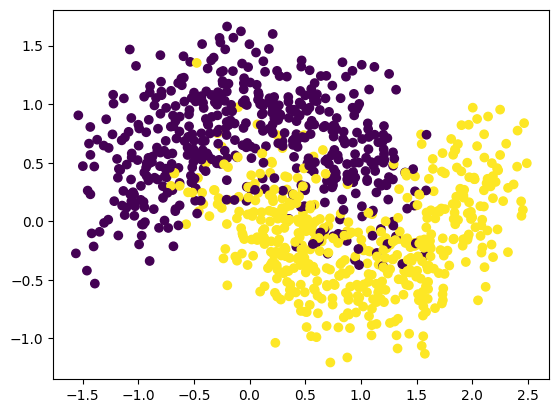

In [107]:
X, y = make_moons(1000, noise=.3)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [110]:
bnn = BNN()
samples = metropolis_hastings(bnn, X, y, proposal_std=0.1, n_samples=10000)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2993.83it/s]


Acceptance rate: 0.0767


# BMA

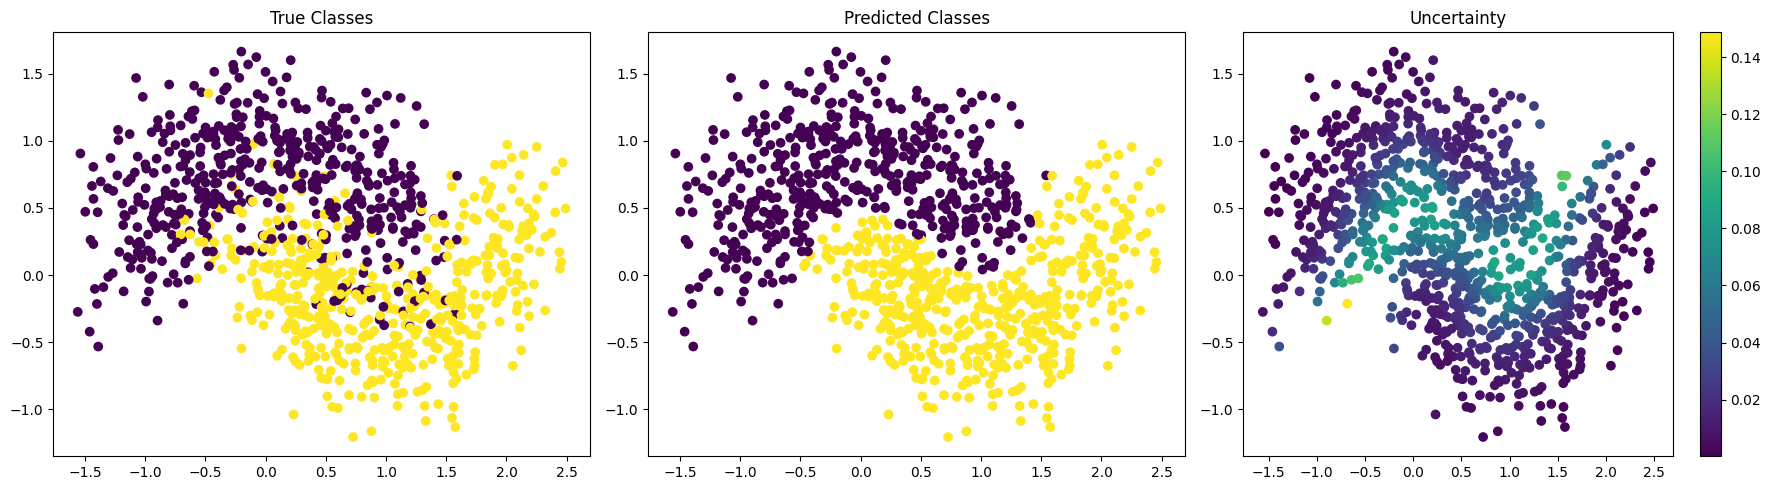

In [112]:
burn_in = round(len(samples) / 2)

preds = np.zeros((len(samples[burn_in:]), X.shape[0]))

for i, sample in enumerate(samples[burn_in:]):
    bnn.load_state_dict(sample)
    preds[i] = bnn(X).detach().squeeze()
    
pred_mean = np.mean(preds, axis=0) 
pred_std = np.std(preds, axis=0) 

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scatter1 = axes[0].scatter(X[:, 0].detach(), X[:, 1].detach(), c=y, cmap='viridis', label='True classes')
axes[0].set_title("True Classes")

scatter2 = axes[1].scatter(X[:, 0].detach(), X[:, 1].detach(), c=np.round(pred_mean), cmap='viridis', label='Predicted classes')
axes[1].set_title("Predicted Classes")

scatter3 = axes[2].scatter(X[:, 0].detach(), X[:, 1].detach(), c=pred_std, cmap='viridis', label='Uncertainty')
axes[2].set_title("Uncertainty")
fig.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

Once again the average of all the predictions results in pretty good seperation of the classes. The frontiere between the classes is not distinct so the uncertainty in this region higher.

# Sources

[Hands-on Bayesian Neural Networks -- a Tutorial for Deep Learning Users, Jospin et al. 2022](https://arxiv.org/abs/2007.06823)

[Machine Learning: a Probabilistic Perspective, Murphy 2012](https://probml.github.io/pml-book/book0.html)